**EXP4 Predicitng Missing Cell-Types from Dissociated and Classic Bulks using the Residual**

Data downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE217517

Cell types per sample from original paper: https://github.com/greenelab/deconvolution_pilot/tree/main/data/cell_labels

*This file includes EXP4 specifics (outlined below), as well as the data preprocessing, QC, and creates the pseudobulks used in other experiments.*

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import celltypist
from celltypist import models

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from scipy.spatial.distance import euclidean
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns
import umap
from sklearn.utils import resample
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

In [2]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_hgsoc_EXP4"
actual_path = os.getcwd()
data_path = f"{actual_path}/../data/EXP4/"
cibersort_path = f"{actual_path}/../data/EXP4/cibersort/"
random_seed = 88
nmf_cut = 'minimum_value'
num_samples = 10000
prop_type = "real"
bulks_type= f"{prop_type}"

## **Reading and QCing the data:**

Classic Bulks (Not Dissociated)

In [3]:
bulks_path = os.path.join(data_path, f"{res_name}_bulks.csv")
bulks_path = Path(bulks_path)
bulks = pd.read_csv(bulks_path)
bulks = bulks.drop(labels=["Unnamed: 0"], axis = 1)
bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
0,7,0,0,6,0,1,28,0,6,1,...,0,0,16,0,0,6,2,4,47,36
1,1,0,0,12,0,0,77,0,10,0,...,0,0,81,0,0,0,2,0,18,13
2,0,0,0,5,0,1,26,0,10,0,...,0,0,8,0,0,0,0,0,46,24
3,0,0,0,3,0,0,51,0,7,0,...,0,0,1,0,6,1,0,0,10,23
4,0,0,0,2,0,0,27,0,12,0,...,0,0,54,0,0,0,1,0,8,0
5,8,0,0,5,0,3,59,0,0,0,...,0,0,3,0,0,0,0,0,18,34
6,0,0,0,5,0,0,81,1,3,0,...,0,0,7,0,1,3,0,0,2,3
7,2,0,0,6,0,2,47,0,6,0,...,0,0,0,0,2,13,0,0,16,7


Dissociated Bulks:

In [4]:
dbulks_path = os.path.join(data_path, f"{res_name}_dissociated_bulks.csv")
dbulks_path = Path(dbulks_path)
diss_bulks = pd.read_csv(dbulks_path)
diss_bulks = diss_bulks.drop(labels=["Unnamed: 0"], axis=1)
diss_bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
0,3,0,0,2,0,0,15,0,1,0,...,0,0,19,0,1,1,3,4,39,28
1,1,0,0,5,0,0,63,1,6,0,...,0,0,27,0,0,0,0,0,8,6
2,3,2,0,1,0,0,7,0,5,0,...,0,0,17,0,0,2,0,0,57,30
3,4,0,0,2,0,0,37,0,2,0,...,0,0,2,0,0,0,0,0,10,21
4,2,0,0,4,0,0,31,0,3,0,...,0,0,6,0,0,6,0,0,6,2
5,1,0,0,1,0,0,33,0,2,0,...,0,0,6,0,0,1,0,0,20,16
6,1,0,0,1,0,0,26,0,5,0,...,0,0,19,0,2,11,0,1,15,3
7,8,0,0,1,0,1,38,0,0,0,...,0,0,4,0,0,4,0,0,10,9


Dissociated polyA:

In [5]:
disspolyA_bulks_path = os.path.join(data_path, f"{res_name}_dissociatedpolyA_bulks.csv")
disspolyA_bulks_path = Path(disspolyA_bulks_path)
disspolya_bulks = pd.read_csv(disspolyA_bulks_path)
disspolya_bulks = disspolya_bulks.drop(labels=["Unnamed: 0"], axis = 1)
disspolya_bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
0,17,2,0,10,0,2,66,0,15,1,...,0,1,35,0,0,9,9,7,56,78
1,2,1,0,7,0,3,134,0,8,0,...,0,4,58,0,1,2,0,0,15,11
2,0,0,0,1,0,0,14,0,10,0,...,0,0,35,0,0,6,0,0,51,27
3,5,1,0,6,0,0,159,0,16,0,...,0,0,2,0,2,6,0,0,27,32
4,4,0,0,13,0,4,92,0,5,0,...,0,0,16,0,0,1,0,0,4,6
5,7,0,0,11,0,9,114,0,12,0,...,0,0,9,0,0,1,0,0,10,17
6,0,0,0,5,0,1,69,0,12,0,...,0,1,33,0,4,30,0,0,6,3
7,2,0,0,6,0,1,93,0,9,1,...,0,0,6,0,2,16,0,0,10,12


In [6]:
#matching index 
bulks.index = range(1,9)
diss_bulks.index = range(1,9)
disspolya_bulks.index = range(1,9)
bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
1,7,0,0,6,0,1,28,0,6,1,...,0,0,16,0,0,6,2,4,47,36
2,1,0,0,12,0,0,77,0,10,0,...,0,0,81,0,0,0,2,0,18,13
3,0,0,0,5,0,1,26,0,10,0,...,0,0,8,0,0,0,0,0,46,24
4,0,0,0,3,0,0,51,0,7,0,...,0,0,1,0,6,1,0,0,10,23
5,0,0,0,2,0,0,27,0,12,0,...,0,0,54,0,0,0,1,0,8,0
6,8,0,0,5,0,3,59,0,0,0,...,0,0,3,0,0,0,0,0,18,34
7,0,0,0,5,0,0,81,1,3,0,...,0,0,7,0,1,3,0,0,2,3
8,2,0,0,6,0,2,47,0,6,0,...,0,0,0,0,2,13,0,0,16,7


And all single-cells:

In [7]:
#saved as anndata objects
adata_path = os.path.join(data_path, f"{res_name}_adata1_notlog.h5ad")
adata_path = Path(adata_path)
adata_1 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata2_notlog.h5ad")
adata_path = Path(adata_path)
adata_2 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata3_notlog.h5ad")
adata_path = Path(adata_path)
adata_3 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata4_notlog.h5ad")
adata_path = Path(adata_path)
adata_4 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata5_notlog.h5ad")
adata_path = Path(adata_path)
adata_5 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata6_notlog.h5ad")
adata_path = Path(adata_path)
adata_6 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata7_notlog.h5ad")
adata_path = Path(adata_path)
adata_7 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata8_notlog.h5ad")
adata_path = Path(adata_path)
adata_8 = sc.read_h5ad(adata_path)

In [8]:
#attaching adatas (sc) into dict
adatas=dict()
adatas[1] = adata_1
adatas[2] = adata_2
adatas[3] = adata_3
adatas[4] = adata_4
adatas[5] = adata_5
adatas[6] = adata_6
adatas[7] = adata_7
adatas[8] = adata_8
#QC
for adata in adatas.items():
    print(adata[1])

AnnData object with n_obs × n_vars = 3102 × 28313
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 1039 × 28578
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 1088 × 28704
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 4329 × 24272
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',

QC imported dataset:

In [9]:
#Our ground truth in this case is single cell
prop_df = dict()
for num in adatas:
    prop_df[num], adatas[num] = vp.get_prop(adatas[num])

                   Num_Cells  Prop_Cells
Cell_Types                              
B cells                   62    0.019987
DC                        13    0.004191
Endothelial cells        503    0.162153
Epithelial cells          56    0.018053
Fibroblasts              206    0.066409
ILC                       24    0.007737
Macrophages              123    0.039652
Monocytes                 54    0.017408
NK cells                 114    0.036750
Plasma cells            1432    0.461638
T cells                  506    0.163121
pDC                        9    0.002901
                   Num_Cells  Prop_Cells
Cell_Types                              
B cells                   41    0.039461
DC                         6    0.005775
Endothelial cells         18    0.017324
Epithelial cells          99    0.095284
Fibroblasts               13    0.012512
Macrophages               26    0.025024
Monocytes                 17    0.016362
NK cells                  67    0.064485
Plasma cells    

In [10]:
for  adata in adatas:
    print(Counter(adatas[adata].obs["cell_types"]))

Counter({'Plasma cells': 1432, 'T cells': 506, 'Endothelial cells': 503, 'Fibroblasts': 206, 'Macrophages': 123, 'NK cells': 114, 'B cells': 62, 'Epithelial cells': 56, 'Monocytes': 54, 'ILC': 24, 'DC': 13, 'pDC': 9})
Counter({'T cells': 734, 'Epithelial cells': 99, 'NK cells': 67, 'B cells': 41, 'Macrophages': 26, 'Endothelial cells': 18, 'Monocytes': 17, 'Fibroblasts': 13, 'Plasma cells': 13, 'DC': 6, 'pDC': 5})
Counter({'Macrophages': 378, 'Fibroblasts': 236, 'Epithelial cells': 236, 'T cells': 142, 'Monocytes': 49, 'NK cells': 26, 'Endothelial cells': 21})
Counter({'T cells': 3053, 'NK cells': 459, 'Macrophages': 274, 'Epithelial cells': 184, 'Fibroblasts': 98, 'pDC': 96, 'Plasma cells': 94, 'DC': 29, 'Endothelial cells': 21, 'B cells': 18, 'Monocytes': 3})
Counter({'T cells': 720, 'Fibroblasts': 274, 'Endothelial cells': 127, 'Epithelial cells': 118, 'pDC': 60, 'NK cells': 53, 'Monocytes': 38, 'Macrophages': 36, 'B cells': 27, 'ILC': 26, 'Plasma cells': 22, 'DC': 19})
Counter({'T 

In [11]:
# Extract the values (Anndata objects) from the dictionary
adatas_list = list(adatas.values())

# Concatenate the Anndata objects into a single object
adata = sc.concat(adatas_list, join='inner')
adata.var['gene_ids'] = adata.var_names
adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 17438 × 13724
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids'

In [12]:
#common genes between adatas and the 
gene_ids = np.intersect1d(bulks.columns, adata.var_names)
bulks = bulks[gene_ids]
diss_bulks = diss_bulks[gene_ids]
disspolya_bulks = disspolya_bulks[gene_ids]

In [13]:
bulks

,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
1,135,98,24716,183,256,2006,1193,917,4091,103,...,439,412,635,1562,221,388,1786,2614,4515,3405
2,107,101,6238,59,220,1214,1144,703,3001,549,...,161,993,296,593,203,304,2435,1305,2166,2644
3,82,85,4221,60,351,823,535,454,1978,100,...,123,439,223,713,271,361,1820,703,563,3075
4,29,35,39378,82,983,736,2297,962,2053,125,...,325,599,169,52,229,559,944,2068,3452,3626
5,51,47,11374,71,62,1027,567,989,1880,134,...,334,346,452,582,188,253,1583,1349,2199,2842
6,300,196,12922,91,618,1365,1235,1281,3525,223,...,370,1441,446,1358,214,251,2067,2039,1344,3102
7,27,28,53177,134,410,852,691,861,2336,68,...,309,511,191,285,218,306,878,1367,3601,3762
8,81,87,31569,150,365,1185,633,727,4366,134,...,283,589,260,116,358,391,1801,2234,3344,5021


In [14]:
# Cutting to only genes that are in the bulks:
adata = adata[:, adata.var_names.isin(gene_ids)].copy()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [15]:
# Identify cells with "Unknown 1" and "Unknown 2" cell types
cells_to_remove = (adata.obs['cell_types'] == 'Unknown1') | (adata.obs['cell_types'] == 'Unknown2')

# Invert the boolean mask to keep cells that do not match the specified cell types
adata = adata[~cells_to_remove, :].copy()
adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 16771 × 13724
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids'

As it is recommended in deconvolution methods, we will delete cells that have low quantities (<50):

In [16]:
Counter(adata.obs["cell_types"])

Counter({'Plasma cells': 1983,
         'Monocytes': 272,
         'T cells': 7419,
         'Endothelial cells': 1189,
         'NK cells': 842,
         'Epithelial cells': 1694,
         'ILC': 89,
         'Fibroblasts': 1587,
         'B cells': 264,
         'DC': 98,
         'Macrophages': 1116,
         'pDC': 170,
         'Mast cells': 27,
         'Erythroid': 21})

In [17]:
# remove cells that are unlabeled or unclassified
cell_type_id = adata.obs["cell_types"].values
cell_type_id = np.unique(cell_type_id)
cell_type_remove = ["Mast cells", "Erythroid"]
cell_type_id = set(cell_type_id).difference(set(cell_type_remove))
adata = adata[adata.obs["cell_types"].isin(cell_type_id)]
#matching obs
print(np.unique(adata.obs["cell_types"].values))

['B cells' 'DC' 'Endothelial cells' 'Epithelial cells' 'Fibroblasts' 'ILC'
 'Macrophages' 'Monocytes' 'NK cells' 'Plasma cells' 'T cells' 'pDC']


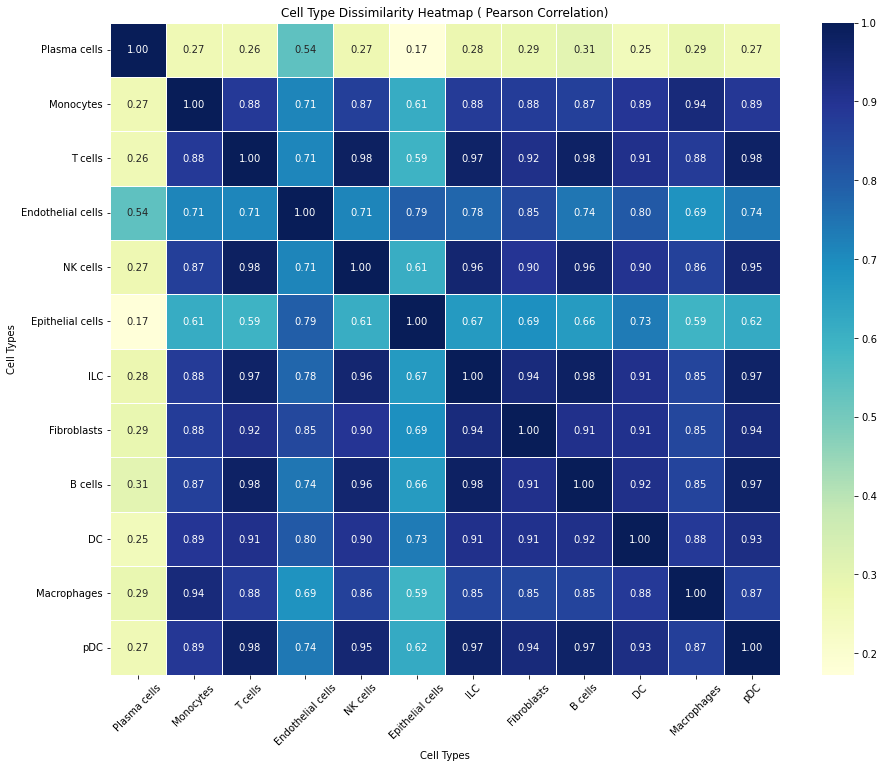

In [18]:
# Define the number of samples for resampling
num_samples = 10000

# Making cell type reference without scaling
cell_types = adata.obs["cell_types"].unique()
gene_ids = adata.var["gene_ids"]
ref_raw = pd.DataFrame(index=gene_ids, columns=cell_types)

for cell_type in cell_types:
    cell_df = adata[adata.obs["cell_types"].isin([cell_type])]
    cell_sample = resample(cell_df, n_samples=num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    ref_raw[cell_type] = sum_over_genes.values

# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a heatmap to visualize the similarities
plt.figure(figsize=(15, 12))
sns.heatmap(similarity_df, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Cell Type Dissimilarity Heatmap ( Pearson Correlation)")
plt.xlabel("Cell Types")
plt.ylabel("Cell Types")
plt.xticks(rotation=45)
plt.show()

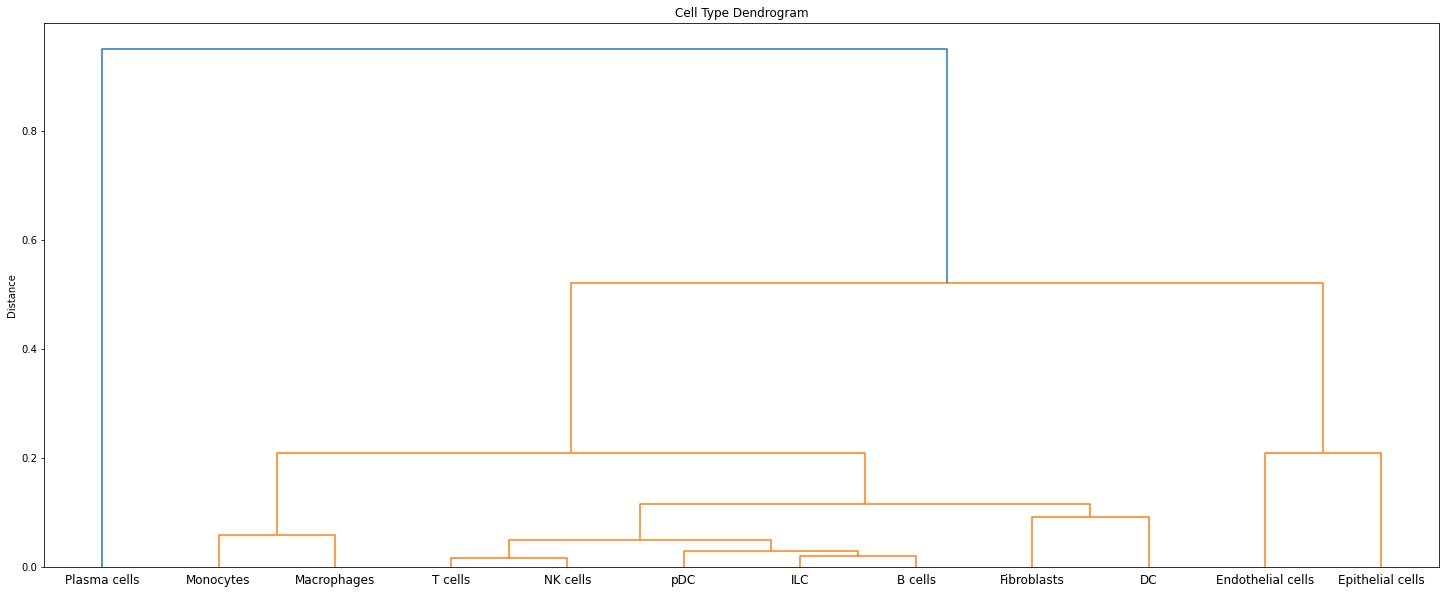

In [19]:
# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =1 - correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a dendrogram to visualize hierarchical clustering
linkage_matrix = linkage(squareform(cell_types_similarity), method='ward')
plt.figure(figsize=(25, 10))
dendrogram(linkage_matrix, labels=cell_types, orientation='top')
plt.title("Cell Type Dendrogram")
plt.ylabel("Distance")
plt.show()

In [20]:
#check cell types in untransformed data
Counter(adata.obs["cell_types"])

Counter({'Plasma cells': 1983,
         'Monocytes': 272,
         'T cells': 7419,
         'Endothelial cells': 1189,
         'NK cells': 842,
         'Epithelial cells': 1694,
         'ILC': 89,
         'Fibroblasts': 1587,
         'B cells': 264,
         'DC': 98,
         'Macrophages': 1116,
         'pDC': 170})

## **Creating Reference**

All Cells Included in Reference,
We need 1 reference, and 3 bulk files for each type of bulk.

In [21]:
# initializing dicitonary for reference
all_refs = dict()

In [22]:
#all cell types included QC
print(Counter(adata.obs.cell_types))
#to dense matrix and saving into path
dense_matrix = adata.X.todense()

dense_df = pd.DataFrame(dense_matrix, columns = adata.var['gene_ids'])
dense_df.insert(loc=0, column='cell_types', value=adata.obs["cell_types"].to_list())
#qc
#save file
dense_df.index = dense_df["cell_types"]
dense_df.pop("cell_types")
sig_df_sn = dense_df
sig_df_sn

Counter({'T cells': 7419, 'Plasma cells': 1983, 'Epithelial cells': 1694, 'Fibroblasts': 1587, 'Endothelial cells': 1189, 'Macrophages': 1116, 'NK cells': 842, 'Monocytes': 272, 'B cells': 264, 'pDC': 170, 'DC': 98, 'ILC': 89})


gene_ids,LINC01409,LINC01128,LINC00115,FAM41C,NOC2L,PLEKHN1,HES4,ISG15,AGRN,C1orf159,...,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,MAFIP,AL354822.1,AC240274.1,AC007325.4
cell_types,,,,,,,,,,,,,,,,,,,,,
Plasma cells,0.0,0.0,0.0,0.0,0.000000,0.692185,0.000000,4.153111,0.000000,0.0,...,22.842112,3.460926,15.920260,5.537482,0.0,11.767149,0.0,0.0,0.0,0.0
Plasma cells,0.0,0.0,0.0,0.0,0.000000,0.000000,15.649452,15.649452,0.000000,0.0,...,31.298904,15.649452,46.948357,0.000000,0.0,46.948357,0.0,0.0,0.0,0.0
Monocytes,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,60.539349,2.751789,19.262520,5.503577,0.0,30.269674,0.0,0.0,0.0,0.0
T cells,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,16.108824,3.579739,10.739216,1.789869,0.0,7.159477,0.0,0.0,0.0,0.0
Endothelial cells,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,19.880716,0.000000,0.0,...,44.731613,2.485090,32.306164,7.455269,0.0,52.186882,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T cells,0.0,0.0,0.0,0.0,0.000000,0.000000,2.134472,2.134472,0.000000,0.0,...,42.689434,2.134472,23.479189,12.806829,0.0,27.748131,0.0,0.0,0.0,0.0
B cells,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,20.172911,0.000000,10.086455,8.645533,0.0,17.291065,0.0,0.0,0.0,0.0
T cells,0.0,0.0,0.0,0.0,1.877934,0.000000,0.000000,0.000000,0.000000,0.0,...,18.779343,3.755868,15.023474,1.877934,0.0,22.535210,0.0,0.0,0.0,0.0


In [23]:
#our reference for all bulks
reference = sig_df_sn
#details
num_str = str(0)
bt = "real"
exp_id = str(res_name)
#and create files for each:
#Classic
this_bulk= bulks
bulks_mix, sig = sn_sc_preprocess.write_cibersortx_files(bp_path = cibersort_path, out_file_id = exp_id, 
                                        sig_df = reference,  X_train = this_bulk, num_str = num_str, bulks_type= bt)

#Dissociated_rrna
this_bulk= diss_bulks
dissbulks_mix, sig = sn_sc_preprocess.write_cibersortx_files(bp_path = cibersort_path, out_file_id = exp_id, 
                                        sig_df = reference,  X_train = this_bulk, num_str = num_str, bulks_type= bt)
#Dissociated_polyA
this_bulk= disspolya_bulks
disspolyabulks_mix, sig = sn_sc_preprocess.write_cibersortx_files(bp_path = cibersort_path, out_file_id = exp_id, 
                                        sig_df = reference,  X_train = this_bulk, num_str = num_str, bulks_type= bt)
                                        

(13724, 16723)
(13724, 16723)
(13724, 16723)


In [24]:
sig

cell_types,Plasma cells,Plasma cells,Monocytes,T cells,Endothelial cells,NK cells,Plasma cells,Plasma cells,Plasma cells,Plasma cells,...,T cells,NK cells,Monocytes,Endothelial cells,NK cells,T cells,B cells,T cells,Epithelial cells,B cells
gene_ids,,,,,,,,,,,,,,,,,,,,,
LINC01409,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LINC01128,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LINC00115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FAM41C,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NOC2L,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,4.105091,0.000000,0.000000,0.000000,0.000000,0.000000,1.877934,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-CYB,11.767149,46.948357,30.269674,7.159477,52.186882,22.403585,34.423409,0.0,20.222446,33.597313,...,21.177465,32.840725,36.083477,70.921982,9.334164,27.748131,17.291065,22.535210,1.452222,54.365204
MAFIP,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AL354822.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,4.235493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Creating bulk files:

In [25]:
#and writing the bulk files for each:
#Classic
method = "classic_rrna"
mix = bulks_mix
sc_profile_file = os.path.join(cibersort_path, f"{exp_id}_{bulks_type}_{method}_mixture.txt")
sc_profile_path = Path(sc_profile_file)
mix.index = gene_ids
mix.to_csv(sc_profile_path, sep='\t', index = True)
mix

,0,1,2,3,4,5,6,7
gene_ids,,,,,,,,
LINC01409,135,107,82,29,51,300,27,81
LINC01128,98,101,85,35,47,196,28,87
LINC00115,24716,6238,4221,39378,11374,12922,53177,31569
FAM41C,183,59,60,82,71,91,134,150
NOC2L,256,220,351,983,62,618,410,365
...,...,...,...,...,...,...,...,...
MT-CYB,388,304,361,559,253,251,306,391
MAFIP,1786,2435,1820,944,1583,2067,878,1801
AL354822.1,2614,1305,703,2068,1349,2039,1367,2234


In [26]:
# Dissociated, rrna
method = "dissociated_rrna"
mix = dissbulks_mix
sc_profile_file = os.path.join(cibersort_path, f"{exp_id}_{bulks_type}_{method}_mixture.txt")
sc_profile_path = Path(sc_profile_file)
mix.index = gene_ids.index
mix.to_csv(sc_profile_path, sep='\t', index = True)
mix

,0,1,2,3,4,5,6,7
LINC01409,197,81,186,82,48,152,94,64
LINC01128,55,59,47,40,19,75,64,24
LINC00115,32868,26055,15846,30034,24867,15348,32943,43311
FAM41C,96,64,24,56,128,67,162,76
NOC2L,420,257,363,1154,325,504,344,769
...,...,...,...,...,...,...,...,...
MT-CYB,449,145,639,782,562,404,409,709
MAFIP,1653,1176,2032,1230,1368,1977,1155,1586
AL354822.1,2287,1078,549,1118,1695,1621,1281,1376
AC240274.1,5759,2800,1638,4364,4183,2411,4836,3119


In [27]:
# Dissociated, polyA
method = "dissociated_polya"
mix = disspolyabulks_mix
sc_profile_file = os.path.join(cibersort_path, f"{exp_id}_{bulks_type}_{method}_mixture.txt")
sc_profile_path = Path(sc_profile_file)
mix.index = gene_ids.index
mix.to_csv(sc_profile_path, sep='\t', index = True)
mix

,0,1,2,3,4,5,6,7
LINC01409,303,145,123,83,29,79,69,55
LINC01128,161,87,35,62,21,51,75,25
LINC00115,85559,54188,24366,67865,26932,22454,40836,60905
FAM41C,130,89,29,62,59,58,37,67
NOC2L,941,514,415,1599,390,565,367,892
...,...,...,...,...,...,...,...,...
MT-CYB,1223,203,1187,1974,732,537,641,1289
MAFIP,4076,1893,3023,2007,1253,2273,1254,2133
AL354822.1,3718,1402,539,1526,1188,1532,940,1435
AC240274.1,31817,8765,4290,12246,8728,5107,10463,8425


And lastly, saving adatas together:

In [28]:
adata_path = os.path.join(data_path, f"{res_name}_adatas_combined.h5ad")
adata_path = Path(adata_path)
adata.write_h5ad(adata_path)
adata

Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'cell_types' as categorical


AnnData object with n_obs × n_vars = 16723 × 13724
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids'

For the next step in processing, run CIBERSORTx in the website or using Docker if you have a code using Run_cibersortx.py